# EM estimate vs direct optimization issue

Here I compare EM with `optim` in a larger simulated data-set involving 50 conditions. Example below is when `EM` and `optim` results are different and `optim` result is better.

In [1]:
dat = readRDS('lite_data_1_artificial_mixture_1_mnm_shared_1.rds')

In [3]:
## r script UUID: 14676992
library(mmbr)
library(flashier)
DSC_A8484812 <- list()
DSC_A8484812 <- dscrutils:::load_inputs(c('lite_data_1.rds','lite_data_1_artificial_mixture_1.rds'), dscrutils:::read_dsc)
DSC_REPLICATE <- DSC_A8484812$DSC_DEBUG$replicate
X <- DSC_A8484812$X
Y <- DSC_A8484812$Y
meta <- DSC_A8484812$meta
eff_mode <- 'shared'
L <- 10
resid_method <- 'oracle'
TIC_A8484812 <- proc.time()
set.seed(DSC_REPLICATE)

## BEGIN DSC CORE
get_center <- function(k,n) {
  if (is.null(k)) {
      return(1:n)
  }
  start = floor(n/2 - k/2)
  end = floor(n/2 + k/2)
  if (start<1) start = 1
  if (end>n) end = n
  return(start:end)
}
center_scale <- function(X) return(susieR:::set_X_attributes(as.matrix(X), center=TRUE, scale = TRUE))
subset_N <- function(gene, N_sub){
    if(!is.null(N_sub)){
        Ntot <- nrow(gene$X)
        to_keep <- sort(sample(x=c(1:Ntot), size=N_sub, replace=F))
        gene$X <- gene$X[to_keep, ]
        gene$y <- gene$y[to_keep]
        gene$Z <- gene$Z[to_keep, ]
        return(gene)
    } else { ###If we don't want to subset individuals
        return(gene)
    }
}
compute_cov_diag <- function(Y){
    covar <- diag(apply(Y, 2, var, na.rm=T))
    return(covar)
}
compute_cov_flash <- function(Y){
    fl <- flashier::flash(Y, var.type = 2, prior.family = c(flashier::prior.normal(), flashier::prior.normal.scale.mix()), backfit = TRUE, verbose.lvl=0)
    if(fl$n.factors==0){
      covar <- diag(fl$residuals.sd^2)
    } else {
      fsd <- sapply(fl$fitted.g[[1]], '[[', "sd")
      covar <- diag(fl$residuals.sd^2) + crossprod(t(fl$flash.fit$EF[[2]]) * fsd)
    }
    s <- diag(apply(Y, 2, sd, na.rm=T))
    covar <- s%*%cov2cor(covar)%*%s
    return(covar)
}
create_missing <- function(Y1, Y0) {
    if (ncol(Y0) < ncol(Y1)) {
        for (i in 1:(ncol(Y1) - ncol(Y0))) {
            Y0 = cbind(Y0, sample(Y0[, sample.int(ncol(Y0), size=1)]))
        }
    }
    if (ncol(Y0) > ncol(Y1)) Y0 = Y0[,sample(1:ncol(Y1))]
    res = Y1
    res[which(is.na(Y0))] = NA
    na_rows = which(apply(res, 1, function(x) all(is.na(x))))
    for (i in na_rows) {
	    non_na = sample.int(ncol(res), size=1)
        res[i,non_na] = Y1[i,non_na]
    }
    return(res)
}
compute_maf <- function(geno){
   f <- mean(geno,na.rm = TRUE)/2
   return(min(f, 1-f))
}
compute_missing <- function(geno){
  miss <- sum(is.na(geno))/length(geno)
  return(miss)
}
mean_impute <- function(geno){
  f <- apply(geno, 2, function(x) mean(x,na.rm = TRUE))
  for (i in 1:length(f)) geno[,i][which(is.na(geno[,i]))] <- f[i]
  return(geno)
}
is_zero_variance <- function(x) {
  if (length(unique(x))==1) return(T)
  else return(F)
}
filter_X <- function(X, missing_rate_thresh, maf_thresh) {
    rm_col <- which(apply(X, 2, compute_missing) > missing_rate_thresh)
    if (length(rm_col)) X <- X[, -rm_col]
    rm_col <- which(apply(X, 2, compute_maf) < maf_thresh)
    if (length(rm_col)) X <- X[, -rm_col]
    rm_col <- which(apply(X, 2, is_zero_variance))
    if (length(rm_col)) X <- X[, -rm_col]
    return(mean_impute(X))
}
prior = meta$prior[[eff_mode]]
if (is.null(prior)) {
    prior = list(xUlist = mmbr:::create_cov_canonical(ncol(Y)))
}
if (resid_method == 'flash') {
    resid_Y <- compute_cov_flash(Y)
} else if (resid_method == 'diag') {
    resid_Y <- compute_cov_diag(Y)
} else {
    resid_Y <- meta$residual_variance
}

Loading required package: mashr

Loading required package: ashr



Script to load simulated data and generate the result is available via `cat(dat$DSC_DEBUG$script)`. Simply copy that code and run the data generation; then run the analysis using `EM` and `optim`.

## EM result

In [25]:
devtools::load_all('~/GIT/software/mmbr')
result = msusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='EM', track_fit=T, precompute_covariances=F)

Loading mmbr



In [26]:
result$V

[1] 0.1331901 0.1331220 0.1327980 0.1326600 0.1326339 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

It seems the prior estimate are consistantly large for all effects. This data-set has 3 simulated signals,

In [27]:
which(rowSums(meta$true_coef) != 0)

[1]  43 129 162

But we have captured 4 effects with non-zero PIP, 2 of them are real.

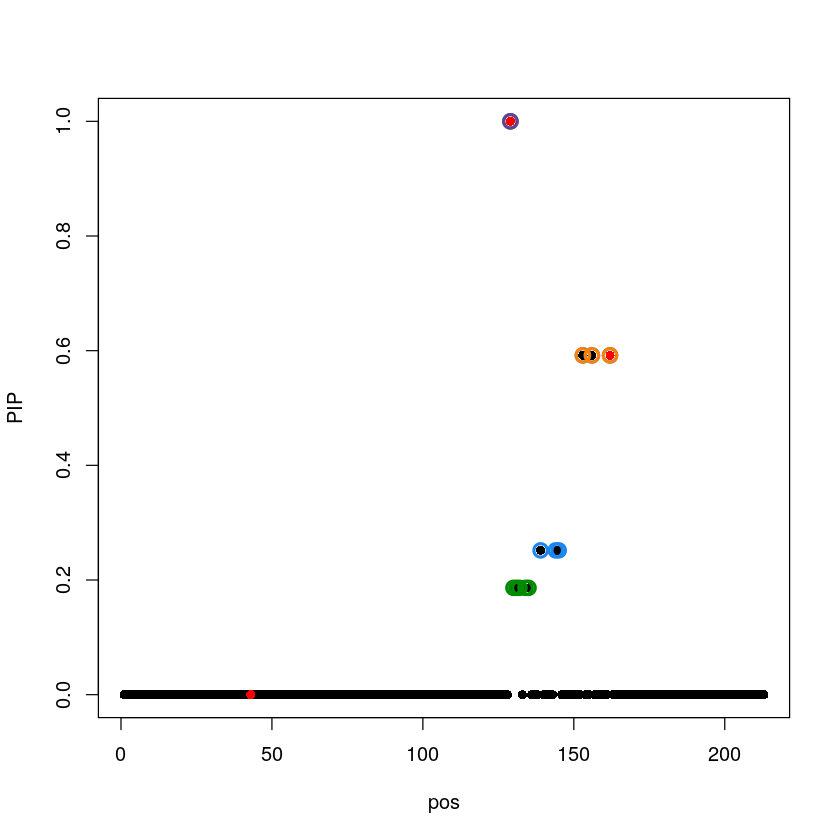

In [28]:
susieR::susie_plot(result, y='PIP',b=rowSums(meta$true_coef))

In [21]:
result$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L1,1.0000000,1.0000000,1.0000000
L2,1.0000000,1.0000000,1.0000000
L4,0.9845723,0.9957145,1.0000000
L5,0.9601872,0.9800936,0.9800936


In [12]:
result$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
6.349176e-142,6.349176e-142,6.349176e-142
3.333311e-01,3.333311e-01,3.333311e-01
1.788361e-11,1.788361e-11,1.788361e-11
8.156961e-02,8.156961e-02,8.156961e-02
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


In [13]:
result$pip[c(153,156,162)]

[1] 0.5918074 0.5918074 0.5918074

In [17]:
result$coef[130,]

[1] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
 [8] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[15] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[22] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[29] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[36] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[43] 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508 0.1276508
[50] 0.1276508

In [33]:
meta$true_coef[129,]

[1] -0.45157952  0.21236242 -0.23139926  1.29082045 -0.13919288  0.45860797
 [7]  1.19081005  0.51950718 -0.44404096  0.55288239  1.02044255 -0.67181462
[13]  0.64829538  0.90472892  0.56318766 -0.38077228  0.34985535 -0.33371293
[19]  0.35185973  0.07553337  1.74655110  0.13276429  0.79027876  1.74287184
[25] -0.35777077 -0.06698781  0.98438493  1.34967008  0.65389743  0.28627559
[31]  0.37316311  0.72586052  0.45548786  1.25877288  0.38942776 -0.53494513
[37]  0.17705649 -0.40382396  0.01924867 -0.15283342  0.80745418  1.16550010
[43]  0.55635426  0.41186611 -0.45398470 -0.35456347  0.59539439 -0.70136776
[49]  1.04218255  1.26042124

In [24]:
result$coef[result$sets$cs$L4+1,]

0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,⋯,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810,0.127650810
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951
0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,⋯,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951,0.006085951


In [43]:
mean(var(Y))

[1] 0.007399244

In [41]:
mean(diag(meta$residual_variance))

[1] 0.1202932

In [48]:
var(Y)

0.1185362659,0.0058174212,0.0156981391,-0.0498283608,0.0184847519,-1.459572e-02,-0.0153816909,-0.0111348095,0.0287768490,-0.0086363510,⋯,-0.0048748258,-0.0343167092,-0.016050102,-0.0018237877,0.0183803358,0.0228742519,-0.0018751758,0.0182906769,-0.018117164,-0.0193231942
0.0058174212,0.0260124101,0.0085204586,-0.0104806431,0.0069205608,5.396690e-04,0.0047525515,0.0014651229,0.0070521792,-0.0145781243,⋯,0.0045204660,-0.0046630616,-0.001281934,0.0021526138,0.0053621776,0.0077774808,0.0034179503,0.0025643709,0.000366391,0.0003816052
0.0156981391,0.0085204586,0.0641801760,-0.0254236302,0.0160320746,-1.172049e-02,-0.0098604938,-0.0064347744,0.0242399273,-0.0212231912,⋯,-0.0020322881,-0.0266383075,-0.010648223,0.0005998810,0.0150355235,0.0202434056,0.0022991208,0.0163442889,-0.013766507,-0.0060087097
-0.0498283608,-0.0104806431,-0.0254236302,0.5229388896,-0.0227326993,2.902225e-02,0.0600860389,0.0255446522,-0.0548822745,0.0295042530,⋯,0.0247081547,0.0803694195,0.041401708,0.0148617274,-0.0459754822,-0.0592300455,0.0149968883,-0.0589343695,0.068223650,0.0586856072
0.0184847519,0.0069205608,0.0160320746,-0.0227326993,0.0569238704,-5.645283e-03,-0.0060631315,-0.0054002424,0.0147928142,-0.0178832100,⋯,-0.0022728738,-0.0184137731,-0.009161973,-0.0015208613,0.0098205954,0.0133014276,-0.0010264131,0.0092684990,-0.011329553,-0.0093450712
-0.0145957176,0.0005396690,-0.0117204878,0.0290222529,-0.0056452829,4.452623e-02,0.0170706543,0.0108304026,-0.0149659385,0.0129021423,⋯,0.0089516222,0.0202900342,0.010684989,0.0043679361,-0.0083671583,-0.0139427543,0.0021478982,-0.0126875531,0.015057034,0.0131906371
-0.0153816909,0.0047525515,-0.0098604938,0.0600860389,-0.0060631315,1.707065e-02,0.1802125929,0.0193968887,-0.0193625310,0.0157523073,⋯,0.0203400975,0.0364360672,0.024545533,0.0111910647,-0.0160526627,-0.0186410575,0.0131434975,-0.0274841826,0.031964815,0.0364127905
-0.0111348095,0.0014651229,-0.0064347744,0.0255446522,-0.0054002424,1.083040e-02,0.0193968887,0.0431000363,-0.0132045829,0.0197266929,⋯,0.0118589599,0.0255265747,0.009515472,0.0057097107,-0.0075916460,-0.0076078899,0.0046686210,-0.0148783477,0.017064408,0.0171387823
0.0287768490,0.0070521792,0.0242399273,-0.0548822745,0.0147928142,-1.496594e-02,-0.0193625310,-0.0132045829,0.1837703686,-0.0207471864,⋯,-0.0128389148,-0.0401478696,-0.021664718,-0.0043193357,0.0151427248,0.0295582901,0.0025467977,0.0302515988,-0.026954341,-0.0271764880
-0.0086363510,-0.0145781243,-0.0212231912,0.0295042530,-0.0178832100,1.290214e-02,0.0157523073,0.0197266929,-0.0207471864,0.9947257559,⋯,-0.0010161518,0.0485801806,0.006920655,0.0071036347,-0.0065036061,-0.0120045492,0.0118829012,-0.0124468194,0.011404048,0.0207870965
-0.0183875923,0.0021875304,-0.0113864724,0.0363406433,-0.0049176387,1.566544e-02,0.0405684906,0.0149209069,-0.0250695789,0.0147901923,⋯,0.0171397954,0.0275524129,0.016017554,0.0085466511,-0.0164180429,-0.0122169878,0.0105492190,-0.0206825595,0.030674768,0.0267086535


## `optim` result

It takes long time to compute, but the PIP is cleaner. The estimated prior scalar is also smaller.

In [8]:
result2 = msusie(X, Y, L=L, prior_variance=matrix(1,50,50), residual_variance=resid_Y, compute_objective=T, estimate_residual_variance=F, estimate_prior_variance=T, 
                estimate_prior_method='optim', track_fit=T, precompute_covariances=F)

In [9]:
result2$V

[1] 0.0007557952 0.0009296375 0.0002614547 0.0000000000 0.0000000000
 [6] 0.0000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000

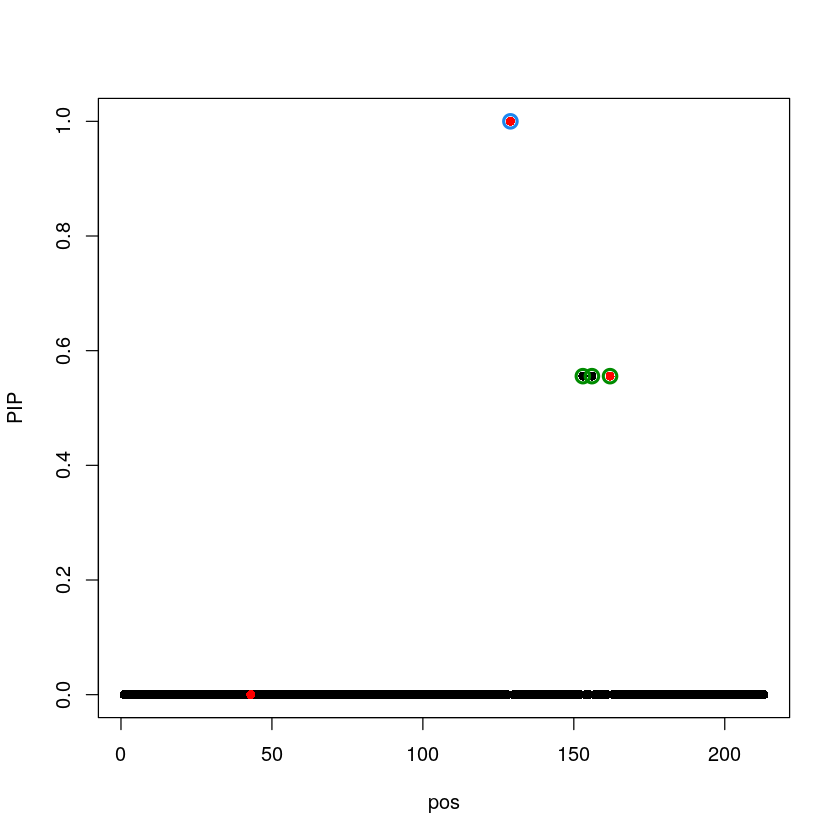

In [10]:
susieR::susie_plot(result2, y='PIP', b=rowSums(meta$true_coef))

In [18]:
result2$alpha[,c(153,156,162)]

3.333333e-01,3.333333e-01,3.333333e-01
1.447861e-221,1.447861e-221,1.447861e-221
3.332946e-01,3.332946e-01,3.332946e-01
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03
4.694836e-03,4.694836e-03,4.694836e-03


In [19]:
result2$pip[c(153,156,162)]

[1] 0.5555297 0.5555297 0.5555297

In [20]:
result2$coef[130,]

[1] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[10] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[19] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[28] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[37] 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662 0.15662
[46] 0.15662 0.15662 0.15662 0.15662 0.15662